[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elepad-org/mlp/blob/main/model/notebook.ipynb)

# 🤖 Multilayer Perceptron

Este Jupyter Notebook implementa una MLP para detectar patrones en una matriz 10x10.
Se genera un dataset para luego entrenar el modelo y validarlo.
Se evalúa la precisión para reiterar sobre el modelo con el objetivo de mejorar su eficacia.
Finalmente se exporta el modelo para ser utilizado en la aplicación web.


## 💡 Situación

En una matriz 10x10 se debe poder detectar las letras `b`, `d`, `f` que se corresponden a los siguientes patrones:

![Patrones que el MLP deberá reconocer](assets/patterns.png)

Se definen en Python los patrones 'b', 'd', y 'f'.
Ante un dato nuevo, el MLP debe ser capaz de clasificar el contenido de la matriz en uno de los tres patrones.


In [21]:
import pandas as pd
import numpy as np
from typing import Literal, TypedDict, Callable
import matplotlib.pyplot as plt

# Extend maximum width when printing DataFrames so they fit in just one line
pd.options.display.width = 100

# Set seed for reproducibility
SEED = 42
RNG = np.random.default_rng(SEED)

CLASSES = ["b", "d", "f"]


def reset_rng():
    """Reset the global RNG to ensure reproducibility across multiple runs."""
    global RNG
    RNG = np.random.default_rng(SEED)


# fmt: off
# Define the 10x10 patterns for 'b', 'd', and 'f' as a 1D array
PATTERNS = {
    "b": np.array(
           [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "d": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "f": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
}
# fmt: on

## 🗃️ Generación de Datasets

Los datasets deben ser representativos a la hora de definir la distribución de los ejemplos de entrenamiento.
Conviene generar el conjunto de datos de manera procedural.
Se crea una función `generate_sample` que crea un ejemplo de un patrón dado con una distorsión entre 0 y 0.3.

La distorsión alterna píxeles seleccionados al azar de entre los 100 píxeles de la matriz, transformando ceros en unos y viceversa.
Una distorsión (_noise_) $n$ alterna $\frac{n * 100}{2}$ píxeles, de manera que una distorsión del $100\%$ alterna el valor de $50$ píxeles y alcanza la entropía máxima.


### 🔄 Reproducibilidad

Para garantizar resultados reproducibles en múltiples ejecuciones del notebook, se implementó una función `reset_rng()` que reinicializa el generador de números aleatorios (`RNG`) a su estado original con la semilla definida (`SEED = 42`).

Esta función se llama:
- Antes de generar los datasets originales
- Al inicio de cada función de entrenamiento (`train_datasets`, `train_with_lr_schedule`, `train_with_sgd`, `train_with_minibatch_sgd`)

De esta manera, ejecutar las celdas múltiples veces producirá exactamente los mismos resultados, lo cual es crucial para:
- Comparar diferentes hiperparámetros de manera justa
- Reproducir experimentos
- Validar resultados

In [22]:
def generate_sample(pattern: Literal["b", "d", "f"], noise: float = 0.0) -> np.ndarray:
    """
    Generates a 1D array based on a given pattern letter ('b', 'd', or 'f'), with optional noise.
    A given noise (between 0 and 1) flips `noise * 100 / 2` pixels, such that a noise
    of 1 flips half the matrix (maximal entropy).

    Args:
        pattern: One of 'b', 'd', or 'f'.
        noise: Proportion of pixels to flip. A noise of 30% will flip 15 out of 100 pixels.
    Returns:
        A numpy 1D array representing the 10x10 matrix with the pattern and noise applied.
    """
    sample = PATTERNS[pattern].copy()
    num_pixels = sample.size
    num_noisy = int(noise * num_pixels / 2)

    if num_noisy > 0:
        # Choose random indices to flip
        indices = RNG.choice(num_pixels, num_noisy, replace=False)
        # Flip the selected pixels (0 becomes 1, 1 becomes 0)
        sample[indices] = 1 - sample[indices]

    return sample


def bold(str: str) -> str:
    """Returns the provided string wrapped in ANSI codes for bold text."""
    return f"\033[1m{str}\033[0m"


def print_sample(sample: np.ndarray):
    """Pretty-prints the provided 1D array as a 10x10 matrix."""
    GREEN = "\033[92m"
    RESET = "\033[0m"
    for i in range(10):
        row = sample[i * 10 : (i + 1) * 10]
        print(" ".join([bold(f"{GREEN}1{RESET}") if val else "0" for val in row]))


print("A 'b' sample with zero noise:")
print_sample(generate_sample("b", 0.00))
print()
print("A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:")
print_sample(generate_sample("b", 0.30))

A 'b' sample with zero noise:
0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 1 1 1 1 0 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0

A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:
0 0 0 0 0 0 0 1 1 0
0 0 1 0 0 0 0 0 1 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 1 1
0 0 1 1 1 1 1 0 0 0
1 0 1 0 0 0 0 0 0 0
0 0 1 0 1 0 0 0 0 0
0 1 0 0 0 1 0 1 1 0
0 0 1 1 1 1 1 0 0 0
0 1 0 0 1 0 0 0 0 0


Luego se generan 3 datasets que contengan 100, 500 y 1000 ejemplos. 
El 10% son patrones sin distorsionar y el resto presentan una distorsión del 1% al 30%.
Se usa una **distribución uniforme** para ubicar el 90% de ejemplos en el rango de distorsión entre 0.01 y 0.30.

Cada dataset es un `pd.DataFrame` de `pandas` que contiene columnas del `0` al `99` (una por cada celda de la matriz) y una columna final `class` que indica la clase del patrón ('b', 'd' o 'f').


In [23]:
def generate_dataset(n_samples: int) -> pd.DataFrame:
    """
    Generates a dataset of pattern samples.
    The 90% of samples will have noise between 0.01 and 0.30.

    Args:
        n_samples: Number of samples to generate.
    Returns:
        A dataframe with 100 columns for the pattern and 1 column 'class' for the pattern class.
    """
    columns = [str(i) for i in range(100)] + ["class"]
    df = pd.DataFrame(0, index=np.arange(n_samples), columns=columns)
    df = df.astype({"class": "str"})

    for i in range(n_samples):
        # 10% without distortion, 90% with distortion between 1% and 30%
        if i < int(0.1 * n_samples):
            noise = 0.0
        else:
            noise = RNG.uniform(0.01, 0.30)

        # Pick a pattern at random
        pattern = RNG.choice(list(PATTERNS.keys()))

        sample = generate_sample(pattern, noise).flatten()
        df.iloc[i, :100] = sample
        df.loc[i, "class"] = pattern

    return df


# Reset RNG for reproducibility across multiple runs
reset_rng()

DATASET_SIZES = [100, 500, 1000]
original_datasets = [generate_dataset(size) for size in DATASET_SIZES]

print("Dataset de 1000 ejemplos:")
original_datasets[2]

Dataset de 1000 ejemplos:


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,f
996,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,f
997,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,b
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d


Por cada dataset se construyen tres conjuntos de validación con 10%, 20% y 30% de los ejemplos, implicando conjuntos de entrenamiento del 90%, 80% y 70%.
Eso da un total de 9 pares de datasets:

| Dataset | Cantidad de Ejemplos | % Entrenamiento | % Validación |
|----|--------------------|-----------------|-------------|
|  1 | 100                | 90%             | 10%         |
|  2 | 100                | 80%             | 20%         |
|  3 | 100                | 70%             | 30%         |
|  4 | 500                | 90%             | 10%         |
|  5 | 500                | 80%             | 20%         |
|  6 | 500                | 70%             | 30%         |
|  7 | 1000               | 90%             | 10%         |
|  8 | 1000               | 80%             | 20%         |
|  9 | 1000               | 70%             | 30%         |

In [24]:
def split_dataset(
    df: pd.DataFrame, validation_ratio: float
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into training and validation sets.

    Args:
        df: The dataset to split.
        validation_ratio: Proportion of the dataset to include in the validation set.
    Returns:
        tuple: (training_df, validation_df).
    """
    shuffled_df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    validation_size = int(len(df) * validation_ratio)
    validation_df = shuffled_df.iloc[:validation_size].reset_index(drop=True)
    training_df = shuffled_df.iloc[validation_size:].reset_index(drop=True)
    return training_df, validation_df


def get_dataset_name(n_samples: int, validation_ratio: float):
    """Returns dataset name for a given number of samples and validation ratio."""
    return f"{n_samples}_samples:val_{int(validation_ratio * 100)}%"


VALIDATION_RATIOS = [0.1, 0.2, 0.3]

# Store all datasets in one dictionary
datasets: dict[str, tuple[pd.DataFrame, pd.DataFrame]] = {}
for df in original_datasets:
    for validation_ratio in VALIDATION_RATIOS:
        training, validation = split_dataset(df, validation_ratio)
        n_samples = df.shape[0]
        key = get_dataset_name(n_samples, validation_ratio)
        datasets[key] = (training, validation)

## 🧠 Implementación del Modelo

Se debe implementar el algoritmo MLP que permita, dado un dataset, parametrizar la cantidad de capas, neuronas y funciones de activación con los que se entrenará la red neuronal.

Requerimientos para la arquitectura del modelo:

- 1 o 2 capas ocultas.
- De 5 a 10 neuronas por capa.
- Funciones de activación: lineal y sigmoidal.
- Coeficiente de aprendizaje entre 0 y 1.
- Término momento entre 0 y 1.

Se estudia el algoritmo utilizando de referencia la bibliografía recomendada por la cátedra [disponible en el campus virtual](https://frre.cvg.utn.edu.ar/pluginfile.php/105673/mod_label/intro/Perceprtr%C3%B3n-MLP.pdf):

- Hilera, J. R. Martinez, V. J. (2000) Redes Neuronales Artificiales. Fundamentos, modelos y aplicaciones. Alfaomega.

También se consulta material complementario para resolver dudas durante la implementación:

- Prince, S. J. D. (2023). Understanding deep learning. The MIT Press. [http://udlbook.com](http://udlbook.com).

### Arquitectura

La arquitectura de esta red neuronal feedforward (MLP) consiste en:

- **Capa de entrada:** 100 neuronas, una por cada celda de la matriz.
- **Capa oculta 1:** 10 neuronas.
- **Capa oculta 2:** 5 neuronas.
- **Capa de salida:** 3 neuronas, una para la clasificación de cada patrón 'b', 'd', 'f'.

Próximamente los hiperparámetros serán parametrizables, pero actualmente se utiliza esta arquitectura como base. 
Los parámetros son inicializados mediante la técnica de Xavier Glorot, y el entrenamiento del MLP consiste en ajustar estos parámetros hasta lograr una pérdida (_loss_) menor a cierta tolerancia.

![Diagrama de la arquitectura del MLP](assets/architecture.png)

Esta red neuronal es una función $f[X, \phi] = Y$ que clasifica el contenido de una matriz 10x10 en uno de tres patrones.
El contenido de la matriz 10x10 se representa como el vector de entrada $X = [x_0, x_1, \dots, x_{99}]^T$.
El vector de salida $Y = [y_b, y_d, y_f]^T$ contiene la predicción del modelo para cada patrón.
El conjunto de parámetros $\phi = \{B_k, W_k\}_{k=0}^K$ del modelo contiene:

- El vector de _biases_ $B_k$ que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1}$.
- Los pesos (_weights_) $W_k$ aplicados a la capa $k$ y que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1} \times D_k$.

La red neuronal se puede representar utilizando notación matricial:

$$
\begin{aligned}
X &= [x_1, x_2, \dots, x_{100}]^T \\
H_1 &= a \left[ B_{1} + W_{1} X \right] \\
H_2 &= a \left[ B_{2} + W_{2} H_1 \right] \\
Y &= B_3 + W_{3} H_2 \\
\end{aligned}
$$

donde $a[\bullet]$ es una función que aplica la función de activación por separado a cada elemento de su vector de entrada.

Esa notación se puede expandir de la siguiente manera (Prince, 2023, p. 48):

$$
\quad \quad \quad \quad \quad
\begin{aligned}
H_1 &= \begin{bmatrix} h_1 \\ h_2 \\ \vdots \\ h_{10} \end{bmatrix} = a \left[ \begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{10}
\end{bmatrix} + \begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1\, 100} \\
w_{21} & w_{22} & \dots & w_{2\ 100} \\
\vdots & \vdots & \ddots & \vdots \\
w_{10 \ 1} & w_{10\, 2} & \dots & w_{10\ 100} \\
\end{bmatrix} \begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{100}
\end{bmatrix} \right]  \\
\end{aligned}
$$

$$
\quad \quad \ \
\begin{aligned}
H_2 &= \begin{bmatrix}
h'_1 \\
h'_2 \\
\vdots \\
h'_5
\end{bmatrix} = a
\left[
\begin{bmatrix}
b'_{1} \\
b'_{2} \\
\vdots \\
b'_{5}
\end{bmatrix}
+
\begin{bmatrix}
w'_{11} & w'_{12} & \dots & w'_{1\ 10} \\
w'_{21} & w'_{22} & \dots & w'_{2\ 10} \\
\vdots & \vdots & \ddots & \vdots \\
w'_{51} & w'_{52} & \dots & w'_{5\ 10} \\
\end{bmatrix}
\begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{10}
\end{bmatrix}
\right]  \\
\end{aligned}
$$

$$
\begin{aligned}
Y &=
\begin{bmatrix}
y_b \\
y_d \\
y_f
\end{bmatrix}
= \begin{bmatrix}
b''_{1} \\
b''_{2} \\
b''_{3}
\end{bmatrix}
+ \begin{bmatrix}
w''_{11} & w''_{12} & \dots & w''_{14} \\
w''_{21} & w''_{22} & \dots & w''_{24} \\
w''_{31} & w''_{32} & \dots & w''_{34} \\
\end{bmatrix}
\begin{bmatrix}
h'_{1} \\
h'_{2} \\
\vdots \\
h'_{5}
\end{bmatrix} \\
\end{aligned}
$$

Por ejemplo, la activación de la segunda neurona de la primera capa oculta se calcula como $h_1 = a[b_1 + w_{21}x_1 + \dots + w_{2\ 100}x_{100}]$.

A diferencia de Prince, Hilera & Martinez sí agregan una función de activación posterior a la capa de salida del MLP.
Para mantener este trabajo alineado con la bibliografía de la cátedra, se prioriza seguir la implementación de Hilera & Martinez.

### Funciones de Activación

Si bien existen múltiples funciones de activación, este trabajo práctico requiere dos en particular:

- Lineal.
- Sigmoidal.

![Funciones de activación](assets/activation_functions.png)


### Regla de Aprendizaje

Se debe elegir la regla de aprendizaje o _loss function_ a utilizar.
Hilera & Martinez (p. 119) presentan la regla _Least Mean Squared_ o _regla delta_:

$$
\epsilon_k^2 = \frac{1}{2L} \sum_{k=1}^L (d_k - s_k)^2
$$


mientras que Prince (p. 62) presenta una función _Least Squares_ similar que omite el coeficiente constante:

$$
L[\phi] = \sum_{i=1}^I (y_i - f[X_i, \phi])^2
$$

Ambas consisten en comparar la salida obtenida contra la deseada para obtener el costo o pérdida.
El costo se debería reducir en cada iteración del entrenamiento del MLP a medida que se ajustan los parámetros.


### Momento

El _momento_ es una modificación al algoritmo _backpropagation_ del gradiente descendiente para suavizar el progreso del algoritmo y evitar oscilaciones.
Matemáticamente es un coeficiente $\beta$ que se agrega para considerar el valor de un parámetro en la iteración anterior al momento de calcular su nuevo valor en la iteración siguiente.

Hilera & Martinez (p. 135) lo presentan como:

$$
\begin{aligned}
w_{ji} (t+1) &= w_{ji}(t) + \alpha \ \delta_{pj}y_{pi} + \underbrace {\beta (w_{ji}(t) - w_{ji} (t-1))}_\text{Término momento} \\
\Delta w_{ji} (t+1) &= \alpha \ \delta_{pj}y_{pi} + \beta \ \Delta w_{ji} (t) \\
\end{aligned}
$$

mientras que Prince (p. 86) lo presenta como:

$$
\begin{aligned}
\mathbf{m}_{t+1} &\leftarrow \beta \cdot \mathbf{m}_t 
  + (1 - \beta) \sum_{i \in \mathcal{B}_t} 
  \frac{\partial \ell_i[\boldsymbol{\phi}_t]}{\partial \boldsymbol{\phi}} \\[6pt]
\boldsymbol{\phi}_{t+1} &\leftarrow 
  \boldsymbol{\phi}_t - \alpha \cdot \mathbf{m}_{t+1}
\end{aligned}
$$

In [25]:
EXPECTED_OUTPUT = {
    "b": np.array([1, 0, 0]),
    "d": np.array([0, 1, 0]),
    "f": np.array([0, 0, 1]),
}


def sigmoid_stable(x):
    """
    Numerically stable sigmoid function to avoid overflow.
    Uses clipping to prevent extreme values.
    """
    x_clipped = np.clip(x, -700, 700)
    return 1.0 / (1.0 + np.exp(-x_clipped))


def sigmoid_derivative_stable(x):
    """Numerically stable sigmoid derivative."""
    s = sigmoid_stable(x)
    return s * (1 - s)

In [26]:
class MLP:
    """Multilayer Perceptron for pattern recognition."""

    def __init__(
        self,
        activation_type: Literal["sigmoid", "linear"] = "sigmoid",
        learning_rate: float = 0.1,
        momentum: float = 0.1,
    ):
        """
        Initialize the MLP with specified hyperparameters.

        Args:
            activation_type: Activation function type ("sigmoid" or "linear")
            learning_rate: Learning rate for gradient descent
            momentum: Momentum coefficient for parameter updates
        """
        self.activation_type = activation_type
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> dict[str, np.ndarray]:
        """
        Initialize weights and biases using Xavier initialization, where each
        parameter will be drawn from a normal distribution with mean of `0` and
        a standard deviation of `sqrt(2 / (input_layer_size + output_layer_size))`
        to help prevent vanishing or exploding gradients.
        """
        # Initialize layer 1 parameters (input -> hidden1)
        std1 = np.sqrt(2.0 / (100 + 10))
        W1 = RNG.normal(0, std1, (10, 100))
        b1 = np.zeros(10)

        # Initialize layer 2 parameters (hidden1 -> hidden2)
        std2 = np.sqrt(2.0 / (10 + 5))
        W2 = RNG.normal(0, std2, (5, 10))
        b2 = np.zeros(5)

        # Initialize output layer parameters (hidden2 -> output)
        std3 = np.sqrt(2.0 / (5 + 3))
        W3 = RNG.normal(0, std3, (3, 5))
        b3 = np.zeros(3)

        return {
            "W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2,
            "W3": W3,
            "b3": b3,
            "delta_W1": np.zeros_like(W1),
            "delta_b1": np.zeros_like(b1),
            "delta_W2": np.zeros_like(W2),
            "delta_b2": np.zeros_like(b2),
            "delta_W3": np.zeros_like(W3),
            "delta_b3": np.zeros_like(b3),
        }

    def get_activation_function(self):
        """Return the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return sigmoid_stable
        elif self.activation_type == "linear":
            return lambda x: x

    def get_activation_derivative(self):
        """Return the derivative of the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return sigmoid_derivative_stable
        elif self.activation_type == "linear":
            return lambda x: np.ones_like(x)

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        """
        Perform a feedforward pass through the network.
        See: Prince, 2023 (page 103) or Hilera & Martinez, 2000 (pages 138-139).

        Args:
            X: Input pattern (100 values).
        Returns:
            Array with all neuron activations at each layer [X, h1, h2, y].
        """
        a = self.get_activation_function()

        # Forward pass from input layer to hidden layer 1
        h1 = a(self.params["b1"] + np.dot(self.params["W1"], X))

        # Forward pass from hidden layer 1 to hidden layer 2
        h2 = a(self.params["b2"] + np.dot(self.params["W2"], h1))

        # Forward pass from hidden layer 2 to output layer
        y = a(self.params["b3"] + np.dot(self.params["W3"], h2))

        return [X, h1, h2, y]

    def backpropagation(self, X: np.ndarray, d: np.ndarray, activations: list) -> dict:
        """
        Backpropagation. See: Hilera & Martinez, 2000 (pages 133-142).

        Args:
            X: Input pattern (100 values).
            d: Target output (3 values).
            activations: Neuron activations from forward pass [X, h1, h2, y_pred].
        Returns:
            Dictionary with updated parameters.
        """
        _, h1, h2, y_pred = activations
        a_derived = self.get_activation_derivative()

        # Output layer (see page 134-135)
        delta3 = (d - y_pred) * a_derived(y_pred)

        delta_W3 = (
            self.learning_rate * np.outer(delta3, h2)
            + self.momentum * self.params["delta_W3"]
        )
        delta_b3 = self.learning_rate * delta3 + self.momentum * self.params["delta_b3"]

        # Hidden layer 2 (see page 135)
        delta2 = np.dot(self.params["W3"].T, delta3) * a_derived(h2)

        delta_W2 = (
            self.learning_rate * np.outer(delta2, h1)
            + self.momentum * self.params["delta_W2"]
        )
        delta_b2 = self.learning_rate * delta2 + self.momentum * self.params["delta_b2"]

        # Hidden layer 1 (see page 135)
        delta1 = np.dot(self.params["W2"].T, delta2) * a_derived(h1)

        delta_W1 = (
            self.learning_rate * np.outer(delta1, X)
            + self.momentum * self.params["delta_W1"]
        )
        delta_b1 = self.learning_rate * delta1 + self.momentum * self.params["delta_b1"]

        # Update parameters (see page 135)
        new_params = self.params.copy()
        new_params["W1"] += delta_W1
        new_params["b1"] += delta_b1
        new_params["W2"] += delta_W2
        new_params["b2"] += delta_b2
        new_params["W3"] += delta_W3
        new_params["b3"] += delta_b3

        # Update momentum terms (see page 135)
        new_params["delta_W1"] = delta_W1
        new_params["delta_b1"] = delta_b1
        new_params["delta_W2"] = delta_W2
        new_params["delta_b2"] = delta_b2
        new_params["delta_W3"] = delta_W3
        new_params["delta_b3"] = delta_b3

        return new_params

    def calculate_loss(self, d: np.ndarray, s: np.ndarray) -> float:
        """Compute least mean squared error loss. See: Hilera & Martinez, 2000 (page 119)."""
        return (1 / (2 * len(d))) * np.sum((d - s) ** 2)

    def classify(self, X: np.ndarray) -> str:
        """
        Classify the input pattern into a class.

        Args:
            X: Input pattern (100 values).
        Returns:
            "b", "d", or "f" according to the maximal output neuron.
        """
        y_pred = self.feedforward(X)[-1]
        idx = int(np.argmax(y_pred))
        return CLASSES[idx]

    def train(
        self, train_data: pd.DataFrame, val_data: pd.DataFrame, tolerance: float = 1e-5
    ) -> dict:
        """
        Train the MLP on a complete dataset using tolerance-based early stopping.
        Computes training loss and validation loss at each epoch.

        Args:
            train_data: DataFrame with 100 feature columns and a 'class' column.
            val_data: Optional validation DataFrame (same format as train_data).
            tolerance: Minimum difference between losses to continue training.
        Returns:
            Dictionary with training and validation history.
        """
        train_losses = []
        val_losses = []
        prev_avg_loss = float("inf")
        epoch = 0

        print(" " + "_" * 41 + " ")
        print(
            f"| {bold('Epoch')} | {bold('Training Loss')} | {bold('Validation Loss')} |"
        )

        while True:
            epoch_loss = 0

            # Training
            for i in range(len(train_data)):
                sample = np.array(train_data.iloc[i, :100].values, dtype=np.float64)
                d = EXPECTED_OUTPUT[train_data.iloc[i, 100]]

                activations = self.feedforward(sample)
                y_pred = activations[-1]
                loss = self.calculate_loss(d, y_pred)
                epoch_loss += loss

                self.params = self.backpropagation(sample, d, activations)

            avg_loss = epoch_loss / len(train_data)
            train_losses.append(avg_loss)

            # Validation metrics
            val_epoch_loss = 0
            for i in range(len(val_data)):
                val_sample = np.array(val_data.iloc[i, :100].values, dtype=np.float64)
                val_d = EXPECTED_OUTPUT[val_data.iloc[i, 100]]

                val_y_pred = self.feedforward(val_sample)[-1]
                val_loss = self.calculate_loss(val_d, val_y_pred)
                val_epoch_loss += val_loss

            val_avg_loss = val_epoch_loss / len(val_data)
            val_losses.append(val_avg_loss)

            # Print progress
            if epoch % 25 == 0:
                print(f"| {epoch:5} |  {avg_loss:11.10f} |  {val_losses[-1]:11.12f} |")

            # Check for stop condition
            loss_change = abs(avg_loss - prev_avg_loss)
            if loss_change < tolerance:
                print(" " + "¯" * 41 + " ")
                print(
                    f"Stopping at epoch {epoch}: Loss change {loss_change} < tolerance={tolerance}"
                )
                break

            prev_avg_loss = avg_loss
            epoch += 1

        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
        }


print("Simple test with a dataset of just one sample:")
single_sample_df = generate_dataset(1)
sample = np.array(single_sample_df.iloc[0, :100].values, dtype=np.float64)
print_sample(sample)
mlp = MLP("sigmoid", 0.1, 0.1)
mlp.train(single_sample_df, single_sample_df, tolerance=0.00001)
c = mlp.classify(sample)
print(f"Pattern classified into class {bold(c)}.")

Simple test with a dataset of just one sample:
0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 1 0 0 0 1 0
0 0 0 1 1 1 0 0 0 1
0 1 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 1 0 1 0 0
1 0 1 0 1 1 1 0 0 0
1 0 0 0 1 0 0 1 0 0
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1120026217 |  0.107539636872 |
|    25 |  0.0373902289 |  0.035908246401 |
|    50 |  0.0151935998 |  0.014722808451 |
|    75 |  0.0075413257 |  0.007357412979 |
|   100 |  0.0043204877 |  0.004235074026 |
|   125 |  0.0027359663 |  0.002690833960 |
|   150 |  0.0018614454 |  0.001835200372 |
|   175 |  0.0013356632 |  0.001319253669 |
|   200 |  0.0009982483 |  0.000987394933 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 207: Loss change 9.897342366163662e-06 < tolerance=1e-05
Pattern classified into class b.


## 🧪 Entrenamiento y Validación

Una vez implementado el MLP con sus algoritmos de feedforward y backpropagation, se puede entrenar el modelo para ajustar los parámetros.
Se entrena un MLP por separado para cada uno de los 9 pares de datasets generados anteriormente.


In [27]:
class TrainingResult(TypedDict):
    dataset_name: str
    mlp: MLP
    epochs: range
    train_losses: list[float]
    val_losses: list[float]


def train_datasets(
    datasets: dict[str, tuple[pd.DataFrame, pd.DataFrame]],
    mlp_factory: Callable[[], MLP | object],
    train_kwargs: dict[str, any] = {},
) -> list[TrainingResult]:
    """
    Train one model per dataset and collect results.
    Args:
        datasets: mapping dataset_name to (train_df, val_df) tuple.
        mlp_factory: function that returns a new MLP or MLP2 instance.
        train_kwargs: optional kwargs forwarded to `mlp.train(...)`.
    Returns:
        list of TrainingResults.
    """
    # Reset RNG before training for reproducibility
    reset_rng()
    
    train_kwargs = train_kwargs
    results: list[TrainingResult] = []

    for key, (train_data, val_data) in datasets.items():
        print(f"\n--- Dataset {key} ---")
        mlp = mlp_factory()
        history = mlp.train(train_data, val_data, **train_kwargs)
        results.append(
            {
                "dataset_name": key,
                "mlp": mlp,
                "epochs": range(len(history["train_losses"])),
                "train_losses": history["train_losses"],
                "val_losses": history["val_losses"],
            }
        )

    print(f"All {len(datasets)} MLPs trained.")
    return results


results = train_datasets(
    datasets,
    lambda: MLP("sigmoid", 0.1, 0.1),
    train_kwargs={"tolerance": 0.000001},
)


--- Dataset 100_samples:val_10% ---
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1225379126 |  0.114732272403 |
|    25 |  0.0026549661 |  0.002968583541 |
|    25 |  0.0026549661 |  0.002968583541 |
|    50 |  0.0002911038 |  0.000440261374 |
|    50 |  0.0002911038 |  0.000440261374 |
|    75 |  0.0001155420 |  0.000281483402 |
|    75 |  0.0001155420 |  0.000281483402 |
|   100 |  0.0000655622 |  0.000232315154 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 108: Loss change 9.88257617721397e-07 < tolerance=1e-06

--- Dataset 100_samples:val_20% ---
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1243945439 |  0.117555165940 |
|   100 |  0.0000655622 |  0.000232315154 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 108: Loss change 9.88257617721397e-07 < tolerance=1e-06

--- Dataset 100_samples:val_20% ---
 ____________________________________

Una vez entrenado un modelo para el dataset de entrenamiento de cada conjunto de datos, se utiliza el dataset de validación asociado para probar la **generalización** del modelo entrenado a nuevos datos que no haya visto antes.

Se grafican los resultados del modelo a lo largo del entrenamiento:

- La evolución del **error global** o pérdida de entrenamiento.
- La evolución del **error de validación**.

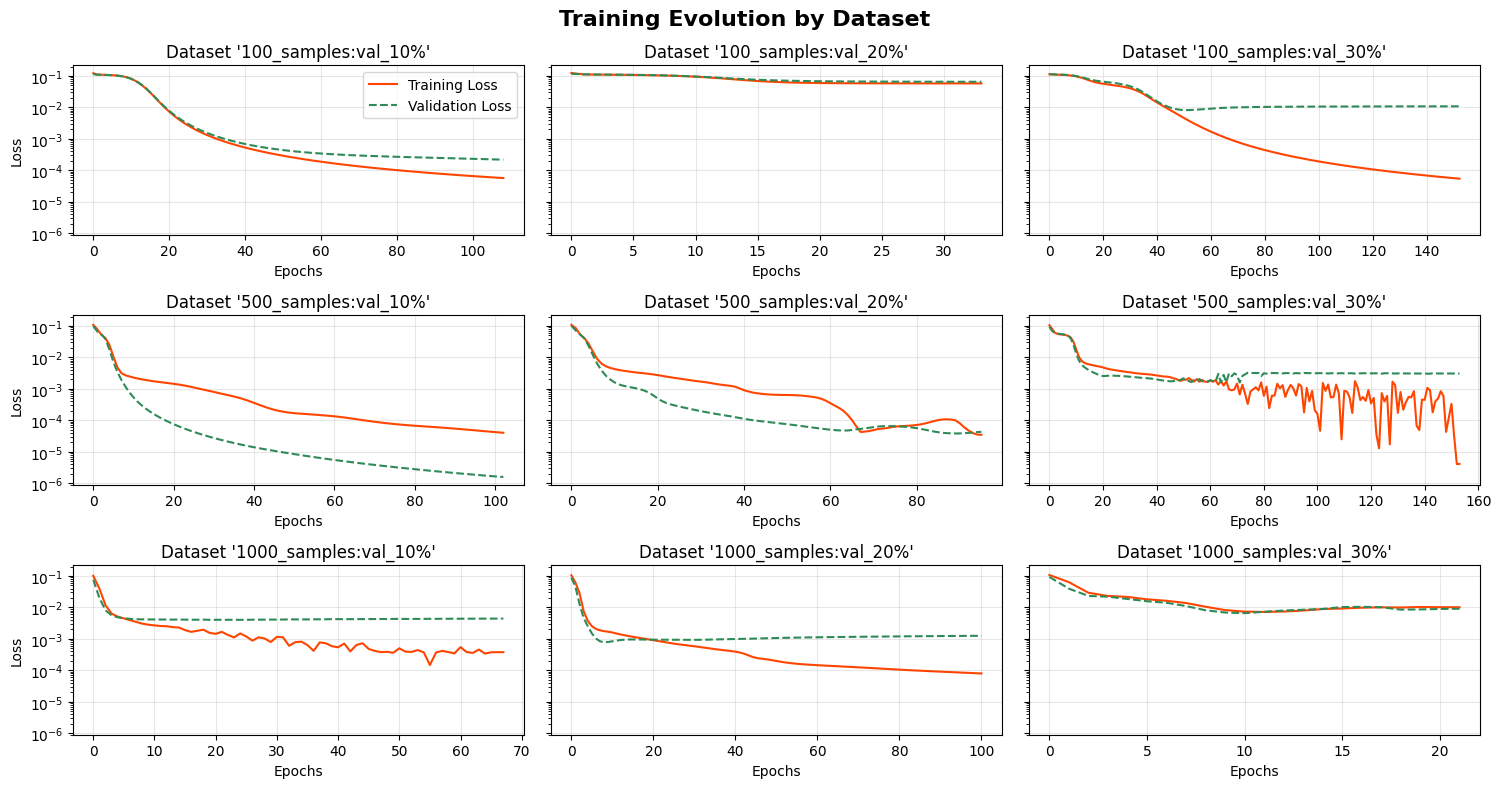

In [28]:
def plot_training_evolution(
    results: list[TrainingResult],
    title: str = "Training Evolution by Dataset",
):
    """
    Plot training and validation loss curves arranged in a grid.
    Args:
        results: list of training results.
        title: figure suptitle.
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 8), sharey=True)
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for idx, res in enumerate(results):
        ax = axes[idx // 3][idx % 3]
        ax.plot(
            res["epochs"], res["train_losses"], color="orangered", label="Training Loss"
        )
        ax.plot(
            res["epochs"], res["val_losses"], color="seagreen", linestyle="--", label="Validation Loss",
        )

        ax.set_yscale("log")
        ax.set_title(f"Dataset '{res['dataset_name']}'")
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Epochs")

        # Set loss label on first column
        if idx % 3 == 0:
            ax.set_ylabel("Loss")

        # Add legend only to the first subplot
        if idx == 0:
            ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


plot_training_evolution(results, title="Training Evolution by Dataset")

In [29]:
def compute_validation_accuracies(results, datasets):
    """Return a pandas.DataFrame with validation accuracy per dataset."""
    rows = []
    for res in results:
        mlp = res["mlp"]
        dataset_name = res["dataset_name"]
        _, val_data = datasets[dataset_name]
        n = len(val_data)
        correct = 0

        for i in range(n):
            sample = np.array(val_data.iloc[i, :100].values, dtype=np.float64)
            true_class = val_data.iloc[i, 100]
            if mlp.classify(sample) == true_class:
                correct += 1
        accuracy = correct / n
        rows.append({"Dataset": dataset_name, "Accuracy": accuracy})

    return pd.DataFrame(rows)


# Compute validation accuracy for each trained model.
compute_validation_accuracies(results, datasets)

,Dataset,Accuracy
0,100_samples:val_10%,1.000000
1,100_samples:val_20%,0.500000
2,100_samples:val_30%,0.966667
3,500_samples:val_10%,1.000000
4,500_samples:val_20%,1.000000
5,500_samples:val_30%,0.973333
6,1000_samples:val_10%,0.980000
7,1000_samples:val_20%,0.995000
8,1000_samples:val_30%,0.963333


## 🪛 Parametrización y Optimización del Modelo

Se han usado los datasets generados para entrenar el MLP implementado y así evaluar su precisión.
Se observa que el modelo no entrena bien en ciertos datasets, y por ende logra una precisión menor en esos casos.
Se quiere **mejorar la precisión del modelo**, para lo cual es necesario ajustar el modelo y mejorar su entrenamiento.

Se lo puede ajustar de varias maneras:

- Usar otra función de activación.
- Modificar la inicialización de los parámetros.
- Probar otros optimizadores (ej: gradiente descendiente estocástico).
- Cambiar la cantidad de capas.
- Cambiar la cantidad de neuronas de cada capa.

Para poder variar los hiperparámetros del modelo, se desarrolla un `MLP2` más complejo que permita esta parametrización.
Luego se volverá a entrenar el modelo para distintas combinaciones de hiperparámetros para encontrar los que logren un mejor comportamiento.
Se analizará el impacto de los hiperparámetros en el entrenamiento del modelo para derivar conclusiones.


In [30]:
class MLP2:
    """Multilayer Perceptron with configurable hyperparameters."""

    def __init__(
        self,
        layers: tuple[int, ...] = (100, 10, 5, 3),
        activation_type: Literal["sigmoid", "linear"] = "sigmoid",
        learning_rate: float = 0.1,
        momentum: float = 0.1,
    ):
        """
        Args:
            layers: Tuple with sizes of input, hidden and output layers.
            activation_type: 'sigmoid' or 'linear'.
            learning_rate: Learning rate for updates.
            momentum: Momentum coefficient for parameter updates.
        """
        self.layers = [int(x) for x in layers]
        self.input_size = self.layers[0]
        self.output_size = self.layers[-1]

        self.activation_type = activation_type
        self.learning_rate = float(learning_rate)
        self.momentum = float(momentum)

        # parameters stored as "W{i}", "b{i}", and momentum deltas "delta_W{i}", "delta_b{i}"
        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> dict[str, np.ndarray]:
        """Xavier-like parameter initialization for arbitrary number of layers using global RNG."""
        params: dict[str, np.ndarray] = {}

        for i in range(len(self.layers) - 1):
            in_dim = self.layers[i]
            out_dim = self.layers[i + 1]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            W = RNG.normal(0.0, std, size=(out_dim, in_dim))
            b = np.zeros(out_dim, dtype=float)

            params[f"W{i}"] = W
            params[f"b{i}"] = b
            params[f"delta_W{i}"] = np.zeros_like(W)
            params[f"delta_b{i}"] = np.zeros_like(b)

        return params

    def get_activation_function(self):
        if self.activation_type == "sigmoid":
            return sigmoid_stable
        elif self.activation_type == "linear":
            return lambda x: x

    def get_activation_derivative(self):
        if self.activation_type == "sigmoid":
            return sigmoid_derivative_stable
        elif self.activation_type == "linear":
            return lambda x: np.ones_like(x)       

    def feedforward(self, X: np.ndarray):
        """Compute forward pass returning list of post-activation arrays:
        [a0 (=X), a1, ..., aL] where aL is network output.
        """
        act = self.get_activation_function()
        activations = [X]
        a = X

        for i in range(len(self.layers) - 1):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            z = b + W.dot(a)
            a = act(z)
            activations.append(a)

        return activations

    def backpropagation(self, X: np.ndarray, d: np.ndarray, activations: list) -> None:
        """Generic backpropagation that updates self.params in-place."""
        a_derived = self.get_activation_derivative()
        L = len(self.layers) - 1  # number of transitions
        a_L = activations[-1]
        delta = (d - a_L) * a_derived(a_L)  # output-layer delta

        # iterate backwards layer by layer
        for i in reversed(range(L)):
            a_prev = activations[i]
            delta_W_key = f"delta_W{i}"
            delta_b_key = f"delta_b{i}"

            # copy current weights for backprop calculation for previous layer
            W_current = self.params[f"W{i}"]

            delta_W = (
                self.learning_rate * np.outer(delta, a_prev)
                + self.momentum * self.params[delta_W_key]
            )
            delta_b = (
                self.learning_rate * delta + self.momentum * self.params[delta_b_key]
            )  

            # update parameters in-place
            self.params[f"W{i}"] += delta_W
            self.params[f"b{i}"] += delta_b

            # store deltas for momentum
            self.params[delta_W_key] = delta_W
            self.params[delta_b_key] = delta_b

            # compute delta for previous layer if any
            if i > 0:
                delta = W_current.T.dot(delta) * a_derived(activations[i])

    def calculate_loss(self, d: np.ndarray, s: np.ndarray) -> float:
        """Least mean squared error."""
        return (1.0 / (2.0 * d.size)) * np.sum((d - s) ** 2)

    def classify(self, X: np.ndarray):
        """Classify input X."""
        y = self.feedforward(X)[-1]
        idx = int(np.argmax(y))
        return CLASSES[idx]

    def train(
        self,
        train_data: pd.DataFrame,
        val_data: pd.DataFrame,
        tolerance: float = 1e-5,
    ) -> dict:
        """Train using sample-by-sample updates."""
        train_losses = []
        val_losses = []
        prev_avg_loss = float("inf")

        print(" " + "_" * 41 + " ")
        print(
            f"| {bold('Epoch')} | {bold('Training Loss')} | {bold('Validation Loss')} |"
        )

        # TODO: probar si reducir el learning rate a medida que pasan las épocas ayuda a evitar las oscilaciones
        # TODO: implementar stochastic gradient descent (SGD) para evitar caer en mínimos locales
        epoch = 0
        while True:
            # training
            epoch_loss = 0.0
            for i in range(len(train_data)):
                sample = np.array(
                    train_data.iloc[i, : self.input_size].values, dtype=float
                )
                d = EXPECTED_OUTPUT[
                    train_data.iloc[i, self.input_size]
                ]  # class at column index == input_size

                activations = self.feedforward(sample)
                y_pred = activations[-1]
                loss = self.calculate_loss(d, y_pred)
                epoch_loss += loss

                self.backpropagation(sample, d, activations)

            avg_loss = epoch_loss / len(train_data)
            train_losses.append(avg_loss)

            # validation
            val_epoch_loss = 0.0
            for i in range(len(val_data)):
                v_sample = np.array(
                    val_data.iloc[i, : self.input_size].values, dtype=float
                )
                v_d = EXPECTED_OUTPUT[val_data.iloc[i, self.input_size]]
                v_y = self.feedforward(v_sample)[-1]
                val_epoch_loss += self.calculate_loss(v_d, v_y)
            val_avg_loss = val_epoch_loss / len(val_data)
            val_losses.append(val_avg_loss)

            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:13.10f} | {val_avg_loss:15.10f} |")

            if abs(avg_loss - prev_avg_loss) < tolerance:
                print(" " + "¯" * 41 + " ")
                print(
                    f"Stopping at epoch {epoch}: Loss change {abs(avg_loss - prev_avg_loss)} < tolerance={tolerance}"
                )
                break

            prev_avg_loss = avg_loss
            epoch += 1

        return {"train_losses": train_losses, "val_losses": val_losses}


print("Simple test with a dataset of just one sample:")
single_sample_df = generate_dataset(1)
sample = np.array(single_sample_df.iloc[0, :100].values, dtype=np.float64)
print_sample(sample)

mlp2 = MLP2(
    layers=(100, 50, 3),
    activation_type="sigmoid",
    learning_rate=0.1,
    momentum=0.1,
)
mlp2.train(single_sample_df, single_sample_df, tolerance=1e-5)
pred = mlp2.classify(sample)
print(f"Pattern classified into class {bold(pred)}.")


Simple test with a dataset of just one sample:
0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 1 1 1 0 0
0 0 0 0 1 0 0 0 0 0
0 0 1 1 1 1 0 0 0 1
0 0 1 1 1 1 1 0 0 0
0 0 0 0 1 0 0 0 0 1
0 1 1 0 1 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1341871465 |    0.1095323513 |
|    25 |  0.0030975850 |    0.0028675719 |
|    50 |  0.0007626120 |    0.0007319691 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 74: Loss change 9.774120805575116e-06 < tolerance=1e-05
Pattern classified into class f.


Una vez implementado el `MLP2`, se experimentará si los siguientes ajustes mejoran el entrenamiento del modelo:

- Utilizar una arquitectura de 2 capas intermedias de 10 neuronas cada una.
- Utilizar Stochastic Gradient Descent (SGD) para intentar evitar mínimos locales en el entrenamiento.
    


--- Dataset 100_samples:val_10% ---
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1151772987 |    0.1086682709 |
|    25 |  0.0216824234 |    0.0153960722 |
|    25 |  0.0216824234 |    0.0153960722 |
|    50 |  0.0002931350 |    0.0002773528 |
|    50 |  0.0002931350 |    0.0002773528 |
|    75 |  0.0000615310 |    0.0000657739 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 94: Loss change 9.931969199758891e-07 < tolerance=1e-06

--- Dataset 100_samples:val_20% ---
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1132403445 |    0.1133914111 |
|    75 |  0.0000615310 |    0.0000657739 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 94: Loss change 9.931969199758891e-07 < tolerance=1e-06

--- Dataset 100_samples:val_20% ---
 _________________________________________ 
| Epoch | Training Loss | Validation Loss |
|     0 |  0.1132403445 |    0.113391

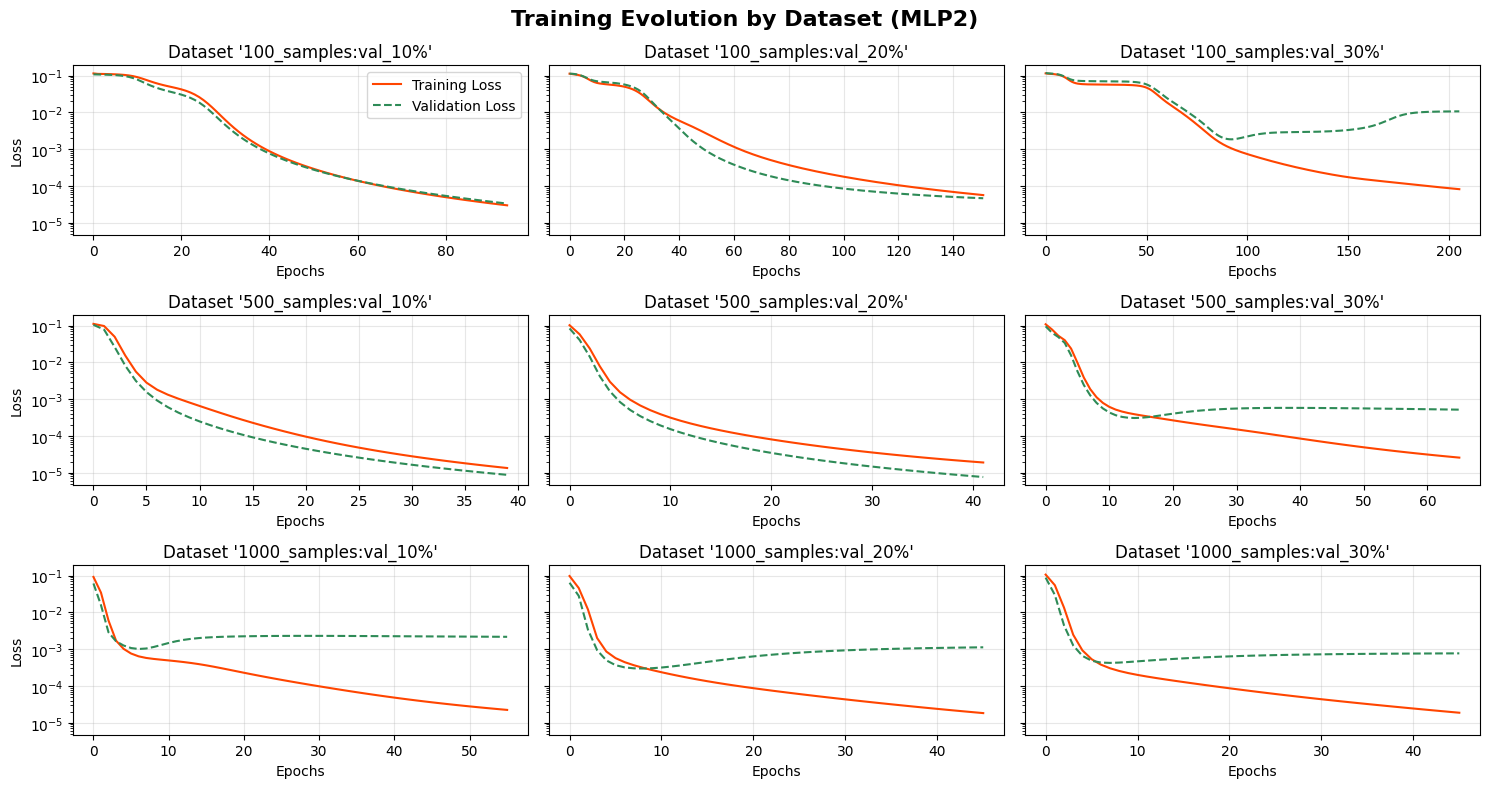

,Dataset,Accuracy
0,100_samples:val_10%,1.000000
1,100_samples:val_20%,1.000000
2,100_samples:val_30%,0.966667
3,500_samples:val_10%,1.000000
4,500_samples:val_20%,1.000000
5,500_samples:val_30%,1.000000
6,1000_samples:val_10%,0.990000
7,1000_samples:val_20%,0.995000
8,1000_samples:val_30%,0.996667


In [31]:
results = train_datasets(
    datasets,
    lambda: MLP2((100, 10, 10, 3), "sigmoid", 0.1, 0.1),
    train_kwargs={"tolerance": 0.000001},
)

plot_training_evolution(results, title="Training Evolution by Dataset (MLP2)")

compute_validation_accuracies(results, datasets)

## Variación de Learning rate

--- Dataset 100_samples:val_10% ---
|     0 |  0.1225435776 |    0.1146859420 |
|    25 |  0.0029134278 |    0.0032479174 |
|    25 |  0.0029134278 |    0.0032479174 |
|    50 |  0.0003157499 |    0.0004474311 |
|    50 |  0.0003157499 |    0.0004474311 |
|    75 |  0.0001227520 |    0.0002212998 |
|    75 |  0.0001227520 |    0.0002212998 |
|   100 |  0.0000670632 |    0.0001377552 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 111: loss_change 9.977552429590302e-07 < tolerance=1e-06
Final learning rate: 0.08507630225817855
--- Dataset 100_samples:val_20% ---
|     0 |  0.1243965699 |    0.1175910436 |
|   100 |  0.0000670632 |    0.0001377552 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 111: loss_change 9.977552429590302e-07 < tolerance=1e-06
Final learning rate: 0.08507630225817855
--- Dataset 100_samples:val_20% ---
|     0 |  0.1243965699 |    0.1175910436 |
|    25 |  0.0578131874 |    0.0657048929 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 


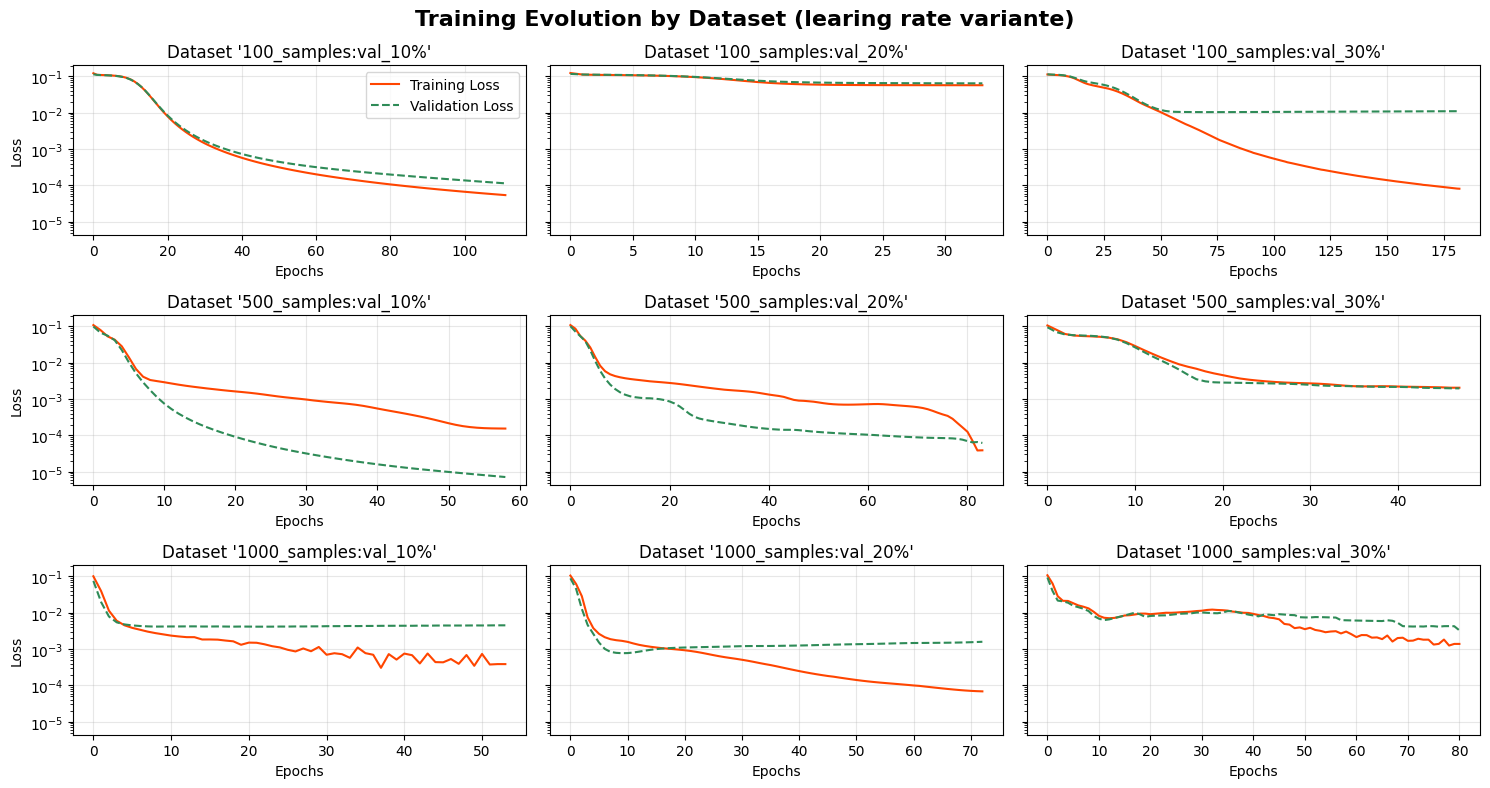

,Dataset,Accuracy
0,100_samples:val_10%,1.000000
1,100_samples:val_20%,0.500000
2,100_samples:val_30%,0.966667
3,500_samples:val_10%,1.000000
4,500_samples:val_20%,1.000000
5,500_samples:val_30%,1.000000
6,1000_samples:val_10%,0.980000
7,1000_samples:val_20%,0.995000
8,1000_samples:val_30%,0.986667


In [32]:
def train_with_lr_schedule(datasets, mlp_factory, initial_lr=0.1, decay=0.02, min_lr=0.05, tolerance=1e-6):
    """Train one MLP per dataset applying a per-epoch multiplicative learning-rate decay."""
    # Reset RNG before training for reproducibility
    reset_rng()
    
    results = []
    for key, (train_df, val_df) in datasets.items():
        print(f"--- Dataset {key} ---")
        mlp = mlp_factory()
        mlp.learning_rate = float(initial_lr)

        train_losses = []
        val_losses = []
        prev_avg_loss = float('inf')
        epoch = 0

        while True:
            epoch_loss = 0.0
            for i in range(len(train_df)):
                sample = np.array(train_df.iloc[i, : mlp.input_size].values, dtype=float)
                d = EXPECTED_OUTPUT[train_df.iloc[i, mlp.input_size]]
                activations = mlp.feedforward(sample)
                y_pred = activations[-1]
                loss = mlp.calculate_loss(d, y_pred)
                epoch_loss += loss
                mlp.backpropagation(sample, d, activations)

            avg_loss = epoch_loss / len(train_df)
            train_losses.append(avg_loss)

            # Validation
            val_epoch_loss = 0.0
            for i in range(len(val_df)):
                v_sample = np.array(val_df.iloc[i, : mlp.input_size].values, dtype=float)
                v_d = EXPECTED_OUTPUT[val_df.iloc[i, mlp.input_size]]
                v_y = mlp.feedforward(v_sample)[-1]
                val_epoch_loss += mlp.calculate_loss(v_d, v_y)
            val_avg_loss = val_epoch_loss / len(val_df)
            val_losses.append(val_avg_loss)

            # update learning rate every 15 epocs
            if epoch % 15 == 0:
                mlp.learning_rate = max(mlp.learning_rate * (1.0 - decay), min_lr)
            # mlp.learning_rate = mlp.learning_rate * (1.0 - decay)  # update learning rate every epoch
            
            
            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:13.10f} | {val_avg_loss:15.10f} |")
            # Stopping condition
            if abs(avg_loss - prev_avg_loss) < tolerance:
                print(" " + "¯" * 41 + " ")
                print(f"Stopping at epoch {epoch}: loss_change {abs(avg_loss - prev_avg_loss)} < tolerance={tolerance}")
                print('Final learning rate:', mlp.learning_rate)
                break

            prev_avg_loss = avg_loss
            epoch += 1

        results.append({
            'dataset_name': key,
            'mlp': mlp,
            'epochs': range(len(train_losses)),
            'train_losses': train_losses,
            'val_losses': val_losses,
        })

    return results

# parametros
results_lr = train_with_lr_schedule(
    datasets,
    lambda: MLP2((100, 10, 5, 3), "sigmoid", 0.1, 0.1),
    tolerance=1e-6,
)

plot_training_evolution(results_lr, title="Training Evolution by Dataset (learing rate variante)")
compute_validation_accuracies(results_lr, datasets)

## Stochastic Gradient Descent 

--- Dataset 100_samples:val_10% (SGD) ---
|     0 |  0.1231147823 |    0.1192836575 |
|    25 |  0.0026331785 |    0.0029970259 |
|    25 |  0.0026331785 |    0.0029970259 |
|    50 |  0.0002834218 |    0.0004122783 |
|    50 |  0.0002834218 |    0.0004122783 |
|    75 |  0.0001071923 |    0.0001989357 |
|    75 |  0.0001071923 |    0.0001989357 |
|   100 |  0.0000565462 |    0.0001198970 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 107: loss_change 9.764024923831238e-07 < tolerance=1e-06
--- Dataset 100_samples:val_20% (SGD) ---
|     0 |  0.1246224309 |    0.1166208780 |
|   100 |  0.0000565462 |    0.0001198970 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 107: loss_change 9.764024923831238e-07 < tolerance=1e-06
--- Dataset 100_samples:val_20% (SGD) ---
|     0 |  0.1246224309 |    0.1166208780 |
|    25 |  0.0097607066 |    0.0126806458 |
|    25 |  0.0097607066 |    0.0126806458 |
|    50 |  0.0047690469 |    0.0076999844 |
|    50 |  0.0047690

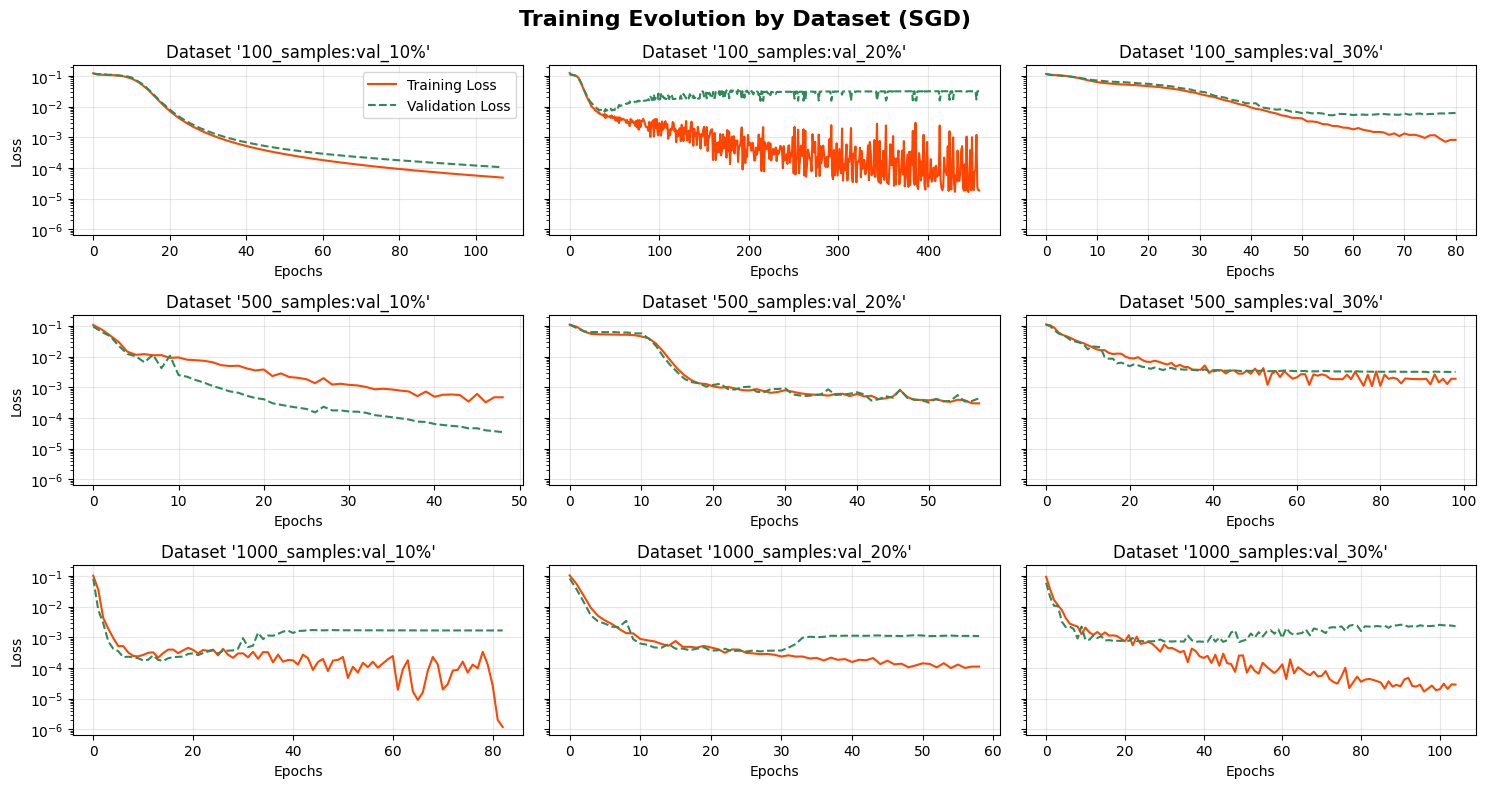

,Dataset,Accuracy
0,100_samples:val_10%,1.000000
1,100_samples:val_20%,0.900000
2,100_samples:val_30%,0.966667
3,500_samples:val_10%,1.000000
4,500_samples:val_20%,1.000000
5,500_samples:val_30%,0.986667
6,1000_samples:val_10%,0.990000
7,1000_samples:val_20%,0.995000
8,1000_samples:val_30%,0.986667


In [33]:
def train_with_sgd(datasets, mlp_factory, batch_size=1, shuffle=True, tolerance=1e-6):
    """Train MLPs using SGD: shuffle training order each epoch and perform sample updates."""
    # Reset RNG before training for reproducibility
    reset_rng()
    
    results = []
    for key, (train_df, val_df) in datasets.items():
        print(f"--- Dataset {key} (SGD) ---")
        mlp = mlp_factory()

        train_losses = []
        val_losses = []
        prev_avg_loss = float('inf')
        epoch = 0
        n_samples = len(train_df)

        while True:
            epoch_loss = 0.0
            if shuffle:
                order = RNG.permutation(n_samples)
            else:
                order = np.arange(n_samples)

            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_idx = order[start:end]
                for i in batch_idx:
                    sample = np.array(train_df.iloc[i, : mlp.input_size].values, dtype=float)
                    d = EXPECTED_OUTPUT[train_df.iloc[i, mlp.input_size]]
                    activations = mlp.feedforward(sample)
                    y_pred = activations[-1]
                    loss = mlp.calculate_loss(d, y_pred)
                    epoch_loss += loss
                    mlp.backpropagation(sample, d, activations)

            avg_loss = epoch_loss / n_samples
            train_losses.append(avg_loss)

            # Validation
            val_epoch_loss = 0.0
            for i in range(len(val_df)):
                v_sample = np.array(val_df.iloc[i, : mlp.input_size].values, dtype=float)
                v_d = EXPECTED_OUTPUT[val_df.iloc[i, mlp.input_size]]
                v_y = mlp.feedforward(v_sample)[-1]
                val_epoch_loss += mlp.calculate_loss(v_d, v_y)
            val_avg_loss = val_epoch_loss / len(val_df)
            val_losses.append(val_avg_loss)

            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:13.10f} | {val_avg_loss:15.10f} |")

            # stopping condition
            if abs(avg_loss - prev_avg_loss) < tolerance:
                print(" " + "¯" * 41 + " ")
                print(f"Stopping at epoch {epoch}: loss_change {abs(avg_loss - prev_avg_loss)} < tolerance={tolerance}")
                break

            prev_avg_loss = avg_loss
            epoch += 1

        results.append({
            'dataset_name': key,
            'mlp': mlp,
            'epochs': range(len(train_losses)),
            'train_losses': train_losses,
            'val_losses': val_losses,
        })

    return results

# parametros
results_sgd = train_with_sgd(
    datasets,
    lambda: MLP2((100, 10, 5, 3), "sigmoid", 0.1, 0.1),
    batch_size=1,
    shuffle=True,
    tolerance=1e-6,
)

plot_training_evolution(results_sgd, title="Training Evolution by Dataset (SGD)")
compute_validation_accuracies(results_sgd, datasets)

## SGD por batches + Learning Rate Variable
- Se puede usar con un learning rate variante

--- Dataset 100_samples:val_10% (Mini-batch SGD) ---
|     0 |  0.1241942836 |    0.1218410896 |
|    25 |  0.1085649599 |    0.1137021917 |
|    25 |  0.1085649599 |    0.1137021917 |
|    50 |  0.1030716080 |    0.1075028081 |
|    50 |  0.1030716080 |    0.1075028081 |
|    75 |  0.0852310041 |    0.0851621415 |
|    75 |  0.0852310041 |    0.0851621415 |
|   100 |  0.0614020681 |    0.0562907635 |
|   100 |  0.0614020681 |    0.0562907635 |
|   125 |  0.0477675078 |    0.0412293251 |
|   125 |  0.0477675078 |    0.0412293251 |
|   150 |  0.0351597478 |    0.0298021151 |
|   150 |  0.0351597478 |    0.0298021151 |
|   175 |  0.0191746788 |    0.0164640719 |
|   175 |  0.0191746788 |    0.0164640719 |
|   200 |  0.0078558690 |    0.0070179694 |
|   200 |  0.0078558690 |    0.0070179694 |
|   225 |  0.0032879873 |    0.0030769068 |
|   225 |  0.0032879873 |    0.0030769068 |
|   250 |  0.0016431790 |    0.0015806560 |
|   250 |  0.0016431790 |    0.0015806560 |
|   275 |  0.0009455541

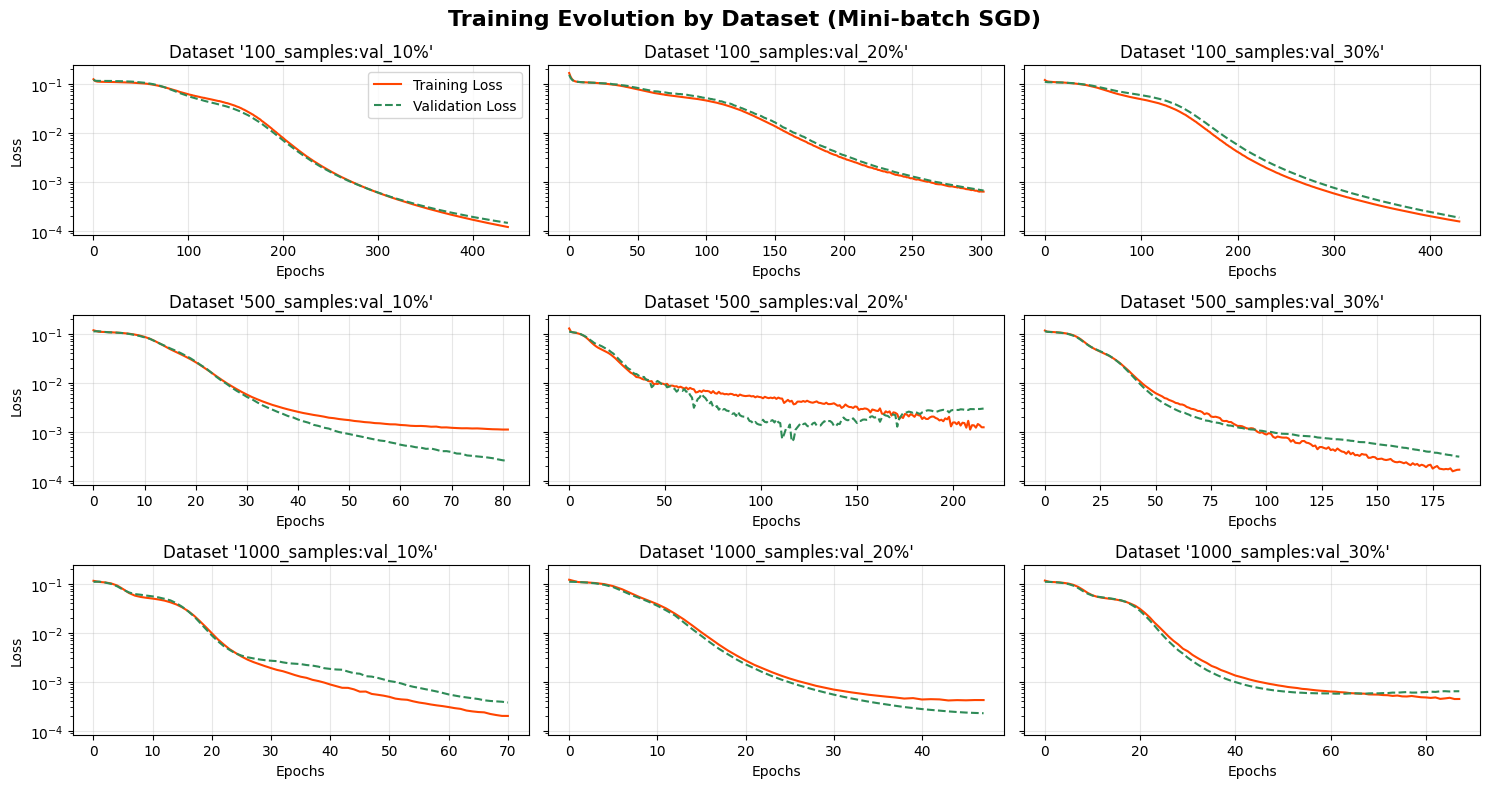

,Dataset,Accuracy
0,100_samples:val_10%,1.000000
1,100_samples:val_20%,1.000000
2,100_samples:val_30%,1.000000
3,500_samples:val_10%,1.000000
4,500_samples:val_20%,0.990000
5,500_samples:val_30%,1.000000
6,1000_samples:val_10%,1.000000
7,1000_samples:val_20%,1.000000
8,1000_samples:val_30%,0.996667


In [35]:
def train_with_minibatch_sgd(datasets, mlp_factory, batch_size=16, shuffle=True, initial_lr=None, decay=0.0, min_lr=None, tolerance=1e-6):
    """Train MLPs using mini-batch SGD where gradients are accumulated over each batch
    and then a single update is applied per batch. Works with MLP2 with any number of layers.
    """
    # Reset RNG before training for reproducibility
    reset_rng()
    
    results = []
    for key, (train_df, val_df) in datasets.items():
        print(f"--- Dataset {key} (Mini-batch SGD) ---")
        mlp = mlp_factory()
        if initial_lr is not None:
            mlp.learning_rate = float(initial_lr)
        if min_lr is None:
            min_lr = mlp.learning_rate

        # Determine number of layers dynamically
        num_layers = len(mlp.layers) - 1  # number of weight matrices

        train_losses = []
        val_losses = []
        prev_avg_loss = float('inf')
        epoch = 0
        n_samples = len(train_df)

        while True:
            epoch_loss = 0.0
            if shuffle:
                order = RNG.permutation(n_samples)
            else:
                order = np.arange(n_samples)

            # iterate in batches and accumulate gradients
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_idx = order[start:end]

                # Initialize gradient accumulators for all layers dynamically
                grad_W = {}
                grad_b = {}
                for layer_idx in range(num_layers):
                    grad_W[layer_idx] = np.zeros_like(mlp.params[f'W{layer_idx}'])
                    grad_b[layer_idx] = np.zeros_like(mlp.params[f'b{layer_idx}'])

                actual_batch_size = len(batch_idx)

                # Accumulate gradients over the batch
                for i in batch_idx:
                    X = np.array(train_df.iloc[i, : mlp.input_size].values, dtype=float)
                    d = EXPECTED_OUTPUT[train_df.iloc[i, mlp.input_size]]

                    activations = mlp.feedforward(X)
                    y_pred = activations[-1]

                    # accumulate loss
                    loss = mlp.calculate_loss(d, y_pred)
                    epoch_loss += loss

                    # Compute gradients using backpropagation logic
                    a_derived = mlp.get_activation_derivative()
                    
                    # Output layer delta
                    delta = (d - y_pred) * a_derived(y_pred)

                    # Backpropagate through all layers
                    for layer_idx in reversed(range(num_layers)):
                        a_prev = activations[layer_idx]
                        
                        # Accumulate gradients
                        grad_W[layer_idx] += np.outer(delta, a_prev)
                        grad_b[layer_idx] += delta

                        # Compute delta for previous layer (if not input layer)
                        if layer_idx > 0:
                            W_current = mlp.params[f'W{layer_idx}']
                            delta = W_current.T.dot(delta) * a_derived(activations[layer_idx])

                # Average gradients over the batch
                for layer_idx in range(num_layers):
                    grad_W[layer_idx] /= actual_batch_size
                    grad_b[layer_idx] /= actual_batch_size

                # Apply learning-rate, momentum and update parameters once per batch
                for layer_idx in range(num_layers):
                    delta_W = mlp.learning_rate * grad_W[layer_idx] + mlp.momentum * mlp.params[f'delta_W{layer_idx}']
                    delta_b = mlp.learning_rate * grad_b[layer_idx] + mlp.momentum * mlp.params[f'delta_b{layer_idx}']

                    # Update parameters in place
                    mlp.params[f'W{layer_idx}'] += delta_W
                    mlp.params[f'b{layer_idx}'] += delta_b

                    # Store momentum terms
                    mlp.params[f'delta_W{layer_idx}'] = delta_W
                    mlp.params[f'delta_b{layer_idx}'] = delta_b

            # epoch finished: compute average training loss
            avg_loss = epoch_loss / n_samples
            train_losses.append(avg_loss)

            # Validation
            val_epoch_loss = 0.0
            for i in range(len(val_df)):
                v_sample = np.array(val_df.iloc[i, : mlp.input_size].values, dtype=float)
                v_d = EXPECTED_OUTPUT[val_df.iloc[i, mlp.input_size]]
                v_y = mlp.feedforward(v_sample)[-1]
                val_epoch_loss += mlp.calculate_loss(v_d, v_y)
            val_avg_loss = val_epoch_loss / len(val_df)
            val_losses.append(val_avg_loss)

            # Print epoch summary
            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:13.10f} | {val_avg_loss:15.10f} |")

            # optional learning-rate decay per epoch
            if decay and min_lr is not None:
                mlp.learning_rate = max(mlp.learning_rate * (1.0 - decay), min_lr)

            # stopping condition
            if abs(avg_loss - prev_avg_loss) < tolerance:
                print(" " + "¯" * 41 + " ")
                print(f"Stopping at epoch {epoch}: loss_change {abs(avg_loss - prev_avg_loss)} < tolerance={tolerance}")
                print('Final learning rate:', mlp.learning_rate)
                break

            prev_avg_loss = avg_loss
            epoch += 1

        results.append({
            'dataset_name': key,
            'mlp': mlp,
            'epochs': range(len(train_losses)),
            'train_losses': train_losses,
            'val_losses': val_losses,
        })

    return results


# parametros
results_minibatch_sgd = train_with_minibatch_sgd(
    datasets,
    lambda: MLP2((100, 10, 10, 3), "sigmoid", 0.1, 0.1),
    batch_size=7,
    shuffle=True,
    initial_lr=0.1,
    decay=0.0,
    min_lr=0.05,
    tolerance=1e-6,
)

plot_training_evolution(results_minibatch_sgd, title="Training Evolution by Dataset (Mini-batch SGD)")
compute_validation_accuracies(results_minibatch_sgd, datasets)

## 🔍 Grid Search de Hiperparámetros

Se implementa una búsqueda exhaustiva (grid search) de combinaciones de hiperparámetros para encontrar la mejor configuración del modelo. Se exploran diferentes:

- Arquitecturas de red (capas ocultas)
- Tamaños de batch para SGD
- Tasas de decaimiento del learning rate

Los resultados se guardan en un CSV para análisis posterior y se generan visualizaciones de cada experimento.

In [36]:
def grid_search_minibatch(datasets):
    """
    Performs grid search over hyperparameters using train_with_minibatch_sgd.
    
    Explores:
    - Hidden layer 1 sizes: [50, 40, 30, 20, 10]
    - Hidden layer 2 sizes: [25, 20, 15, 10, 5]
    - Decay rates: [0.01, 0.02, 0.05]
    - Batch sizes: [16, 8]
    
    Returns:
        DataFrame with results for all experiments saved to 'grid_search_results.csv'
    """
    import os
    
    # Define hyperparameter grid
    h1_sizes = [50, 40, 30, 20, 10]
    h2_sizes = [25, 20, 15, 10, 5]
    decay_rates = [0.01, 0.02, 0.05]
    batch_sizes = [16, 8]
    
    # Fixed hyperparameters
    initial_lr = 0.1
    min_lr = 0.05
    tolerance = 1e-6
    
    # Get sorted dataset keys for consistent ordering
    dataset_keys = sorted(datasets.keys())
    
    # Results storage
    all_results = []
    
    # Total number of experiments
    total_experiments = len(h1_sizes) * len(h2_sizes) * len(decay_rates) * len(batch_sizes)
    experiment_num = 0
    
    print(f"Starting grid search: {total_experiments} total experiments")
    print("=" * 80)
    
    # Iterate over all combinations
    for h1 in h1_sizes:
        for h2 in h2_sizes:
            for decay in decay_rates:
                for batch_size in batch_sizes:
                    experiment_num += 1
                    
                    # Create experiment name
                    decay_pct = int(decay * 100)
                    experiment_name = f"lr{initial_lr:.2f}_decay{decay_pct}pct_bs{batch_size}_layers100-{h1}-{h2}-3"
                    
                    print(f"\n[{experiment_num}/{total_experiments}] Starting: {experiment_name}")
                    
                    # Reset RNG for reproducibility
                    reset_rng()
                    
                    # Create MLP factory
                    def mlp_factory():
                        return MLP2(
                            layers=(100, h1, h2, 3),
                            activation_type="sigmoid",
                            learning_rate=initial_lr,
                            momentum=0.1
                        )
                    
                    # Train with minibatch SGD
                    results = train_with_minibatch_sgd(
                        datasets=datasets,
                        mlp_factory=mlp_factory,
                        batch_size=batch_size,
                        shuffle=True,
                        initial_lr=initial_lr,
                        decay=decay,
                        min_lr=min_lr,
                        tolerance=tolerance
                    )
                    
                    # Build result row
                    row = {"experiment": experiment_name}
                    
                    # Track metrics for finding best dataset
                    dataset_metrics = {}
                    
                    # Process each dataset result
                    for res in results:
                        dataset_name = res["dataset_name"]
                        mlp = res["mlp"]
                        val_losses = res["val_losses"]
                        
                        # Compute accuracy for this dataset
                        _, val_data = datasets[dataset_name]
                        n = len(val_data)
                        correct = 0
                        for i in range(n):
                            sample = np.array(val_data.iloc[i, :100].values, dtype=np.float64)
                            true_class = val_data.iloc[i, 100]
                            if mlp.classify(sample) == true_class:
                                correct += 1
                        accuracy = correct / n
                        
                        # Compute loss metrics
                        val_loss_mean = np.mean(val_losses)
                        val_loss_min = np.min(val_losses)
                        val_loss_final = val_losses[-1]
                        
                        # Store in row
                        row[f"{dataset_name}_accuracy"] = accuracy
                        row[f"{dataset_name}_val_loss_mean"] = val_loss_mean
                        row[f"{dataset_name}_val_loss_final"] = val_loss_final
                        
                        # Track for best dataset
                        dataset_metrics[dataset_name] = val_loss_mean
                    
                    # Find best dataset (minimum mean validation loss)
                    best_dataset = min(dataset_metrics, key=dataset_metrics.get)
                    row["best_dataset_by_min_val_loss"] = best_dataset
                    
                    # Add to results
                    all_results.append(row)
                    
                    # Plot training evolution for this experiment
                    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
                    fig.suptitle(f"Experiment: {experiment_name}", fontsize=16, fontweight="bold")
                    
                    for idx, res in enumerate(results):
                        ax = axes[idx // 3][idx % 3]
                        ax.plot(
                            res["epochs"], 
                            res["train_losses"], 
                            color="orangered", 
                            label="Training Loss"
                        )
                        ax.plot(
                            res["epochs"], 
                            res["val_losses"], 
                            color="seagreen", 
                            linestyle="--", 
                            label="Validation Loss"
                        )
                        
                        ax.set_yscale("log")
                        ax.set_title(f"Dataset '{res['dataset_name']}'", fontsize=10)
                        ax.grid(True, alpha=0.3)
                        ax.set_xlabel("Epochs")
                        
                        # Set loss label on first column
                        if idx % 3 == 0:
                            ax.set_ylabel("Loss")
                        
                        # Add legend only to the first subplot
                        if idx == 0:
                            ax.legend(loc="upper right", fontsize=8)
                    
                    plt.tight_layout()
                    
                    # Save figure
                    figure_filename = f"grid_search_{experiment_name}.png"
                    plt.savefig(figure_filename, dpi=100, bbox_inches='tight')
                    plt.show()
                    plt.close()
                    
                    print(f"Experiment {experiment_name} finished")
                    print(f"  - Best dataset: {best_dataset} (val_loss_mean={dataset_metrics[best_dataset]:.6f})")
                    print(f"  - Figure saved: {figure_filename}")
    
    # Create DataFrame and save to CSV
    df_results = pd.DataFrame(all_results)
    csv_filename = "grid_search_results.csv"
    df_results.to_csv(csv_filename, index=False)
    
    print("\n" + "=" * 80)
    print(f"Grid search completed!")
    print(f"Results saved to: {csv_filename}")
    print(f"Total experiments: {len(all_results)}")
    
    return df_results

Starting grid search: 150 total experiments

[1/150] Starting: lr0.10_decay1pct_bs16_layers100-50-25-3
--- Dataset 100_samples:val_10% (Mini-batch SGD) ---
|     0 |  0.1292682740 |    0.1221577770 |
|    25 |  0.1028491973 |    0.1075114740 |
|    25 |  0.1028491973 |    0.1075114740 |
|    50 |  0.0958150389 |    0.1006789136 |
|    50 |  0.0958150389 |    0.1006789136 |
|    75 |  0.0876552135 |    0.0916934409 |
|    75 |  0.0876552135 |    0.0916934409 |
|   100 |  0.0782969578 |    0.0808022268 |
|   100 |  0.0782969578 |    0.0808022268 |
|   125 |  0.0680952782 |    0.0693268830 |
|   125 |  0.0680952782 |    0.0693268830 |
|   150 |  0.0594979818 |    0.0587564915 |
|   150 |  0.0594979818 |    0.0587564915 |
|   175 |  0.0531062370 |    0.0520799004 |
|   175 |  0.0531062370 |    0.0520799004 |
|   200 |  0.0472834389 |    0.0458181406 |
|   200 |  0.0472834389 |    0.0458181406 |
|   225 |  0.0412521741 |    0.0394969536 |
|   225 |  0.0412521741 |    0.0394969536 |
|   250 

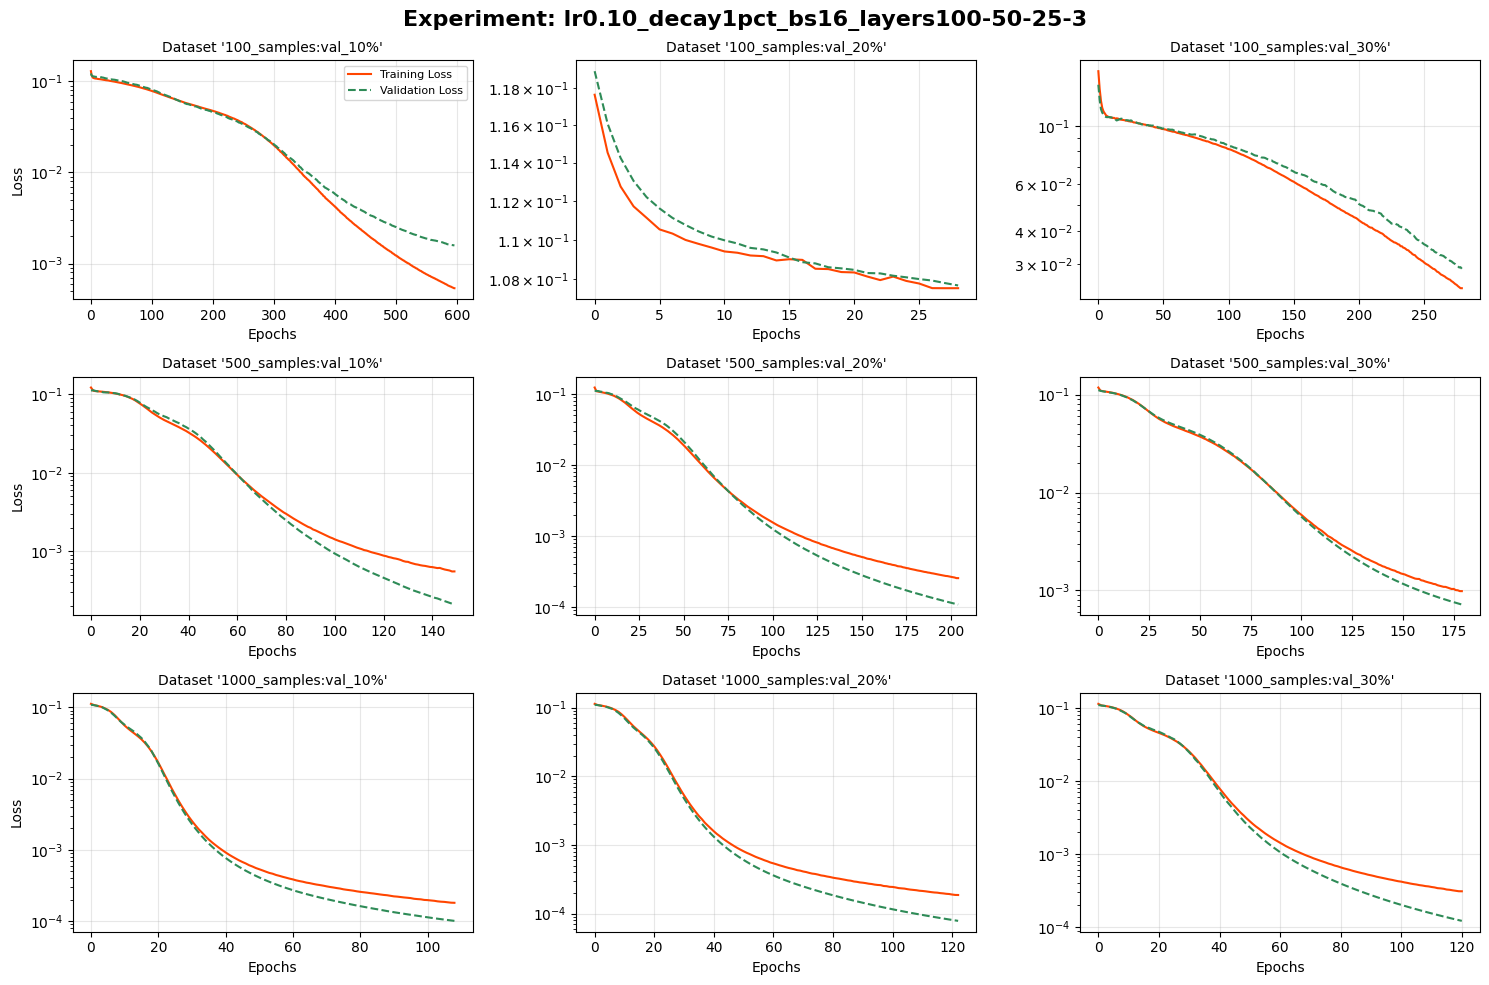

Experiment lr0.10_decay1pct_bs16_layers100-50-25-3 finished
  - Best dataset: 1000_samples:val_10% (val_loss_mean=0.012822)
  - Figure saved: grid_search_lr0.10_decay1pct_bs16_layers100-50-25-3.png

[2/150] Starting: lr0.10_decay1pct_bs8_layers100-50-25-3
--- Dataset 100_samples:val_10% (Mini-batch SGD) ---
|     0 |  0.1243333862 |    0.1189899044 |
|    25 |  0.0934314486 |    0.0974449783 |
|    25 |  0.0934314486 |    0.0974449783 |
|    50 |  0.0679835139 |    0.0691383721 |
|    50 |  0.0679835139 |    0.0691383721 |
|    75 |  0.0516516756 |    0.0508491620 |
|    75 |  0.0516516756 |    0.0508491620 |
|   100 |  0.0395711530 |    0.0382038362 |
|   100 |  0.0395711530 |    0.0382038362 |
|   125 |  0.0253899607 |    0.0253673973 |
|   125 |  0.0253899607 |    0.0253673973 |
|   150 |  0.0118876470 |    0.0126543866 |
|   150 |  0.0118876470 |    0.0126543866 |
|   175 |  0.0055053190 |    0.0070737173 |
|   175 |  0.0055053190 |    0.0070737173 |
|   200 |  0.0026038299 |    0.

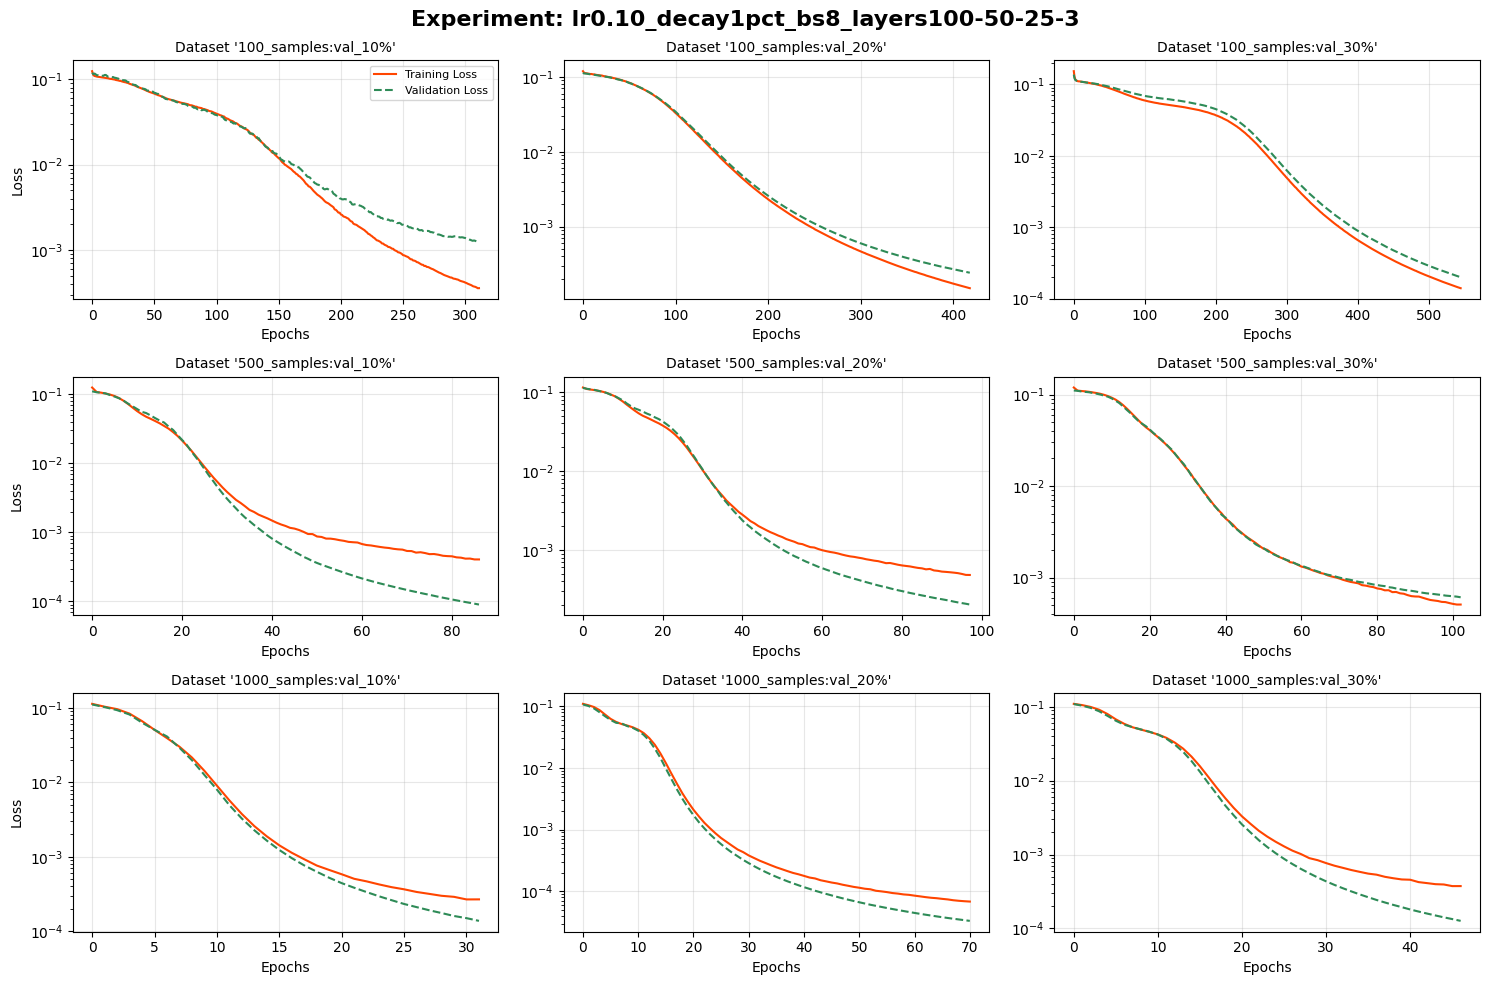

Experiment lr0.10_decay1pct_bs8_layers100-50-25-3 finished
  - Best dataset: 1000_samples:val_20% (val_loss_mean=0.012406)
  - Figure saved: grid_search_lr0.10_decay1pct_bs8_layers100-50-25-3.png

[3/150] Starting: lr0.10_decay2pct_bs16_layers100-50-25-3
--- Dataset 100_samples:val_10% (Mini-batch SGD) ---
|     0 |  0.1292682740 |    0.1221577770 |
|    25 |  0.1035955813 |    0.1085337899 |
|    25 |  0.1035955813 |    0.1085337899 |
|    50 |  0.0988765471 |    0.1040035354 |
|    50 |  0.0988765471 |    0.1040035354 |
|    75 |  0.0925321855 |    0.0970758054 |
|    75 |  0.0925321855 |    0.0970758054 |
|   100 |  0.0843100163 |    0.0875456449 |
|   100 |  0.0843100163 |    0.0875456449 |
|   125 |  0.0741993707 |    0.0762375727 |
|   125 |  0.0741993707 |    0.0762375727 |
|   150 |  0.0645328448 |    0.0645310691 |
|   150 |  0.0645328448 |    0.0645310691 |
|   175 |  0.0569664001 |    0.0564852391 |
|   175 |  0.0569664001 |    0.0564852391 |
|   200 |  0.0507364348 |    0.0

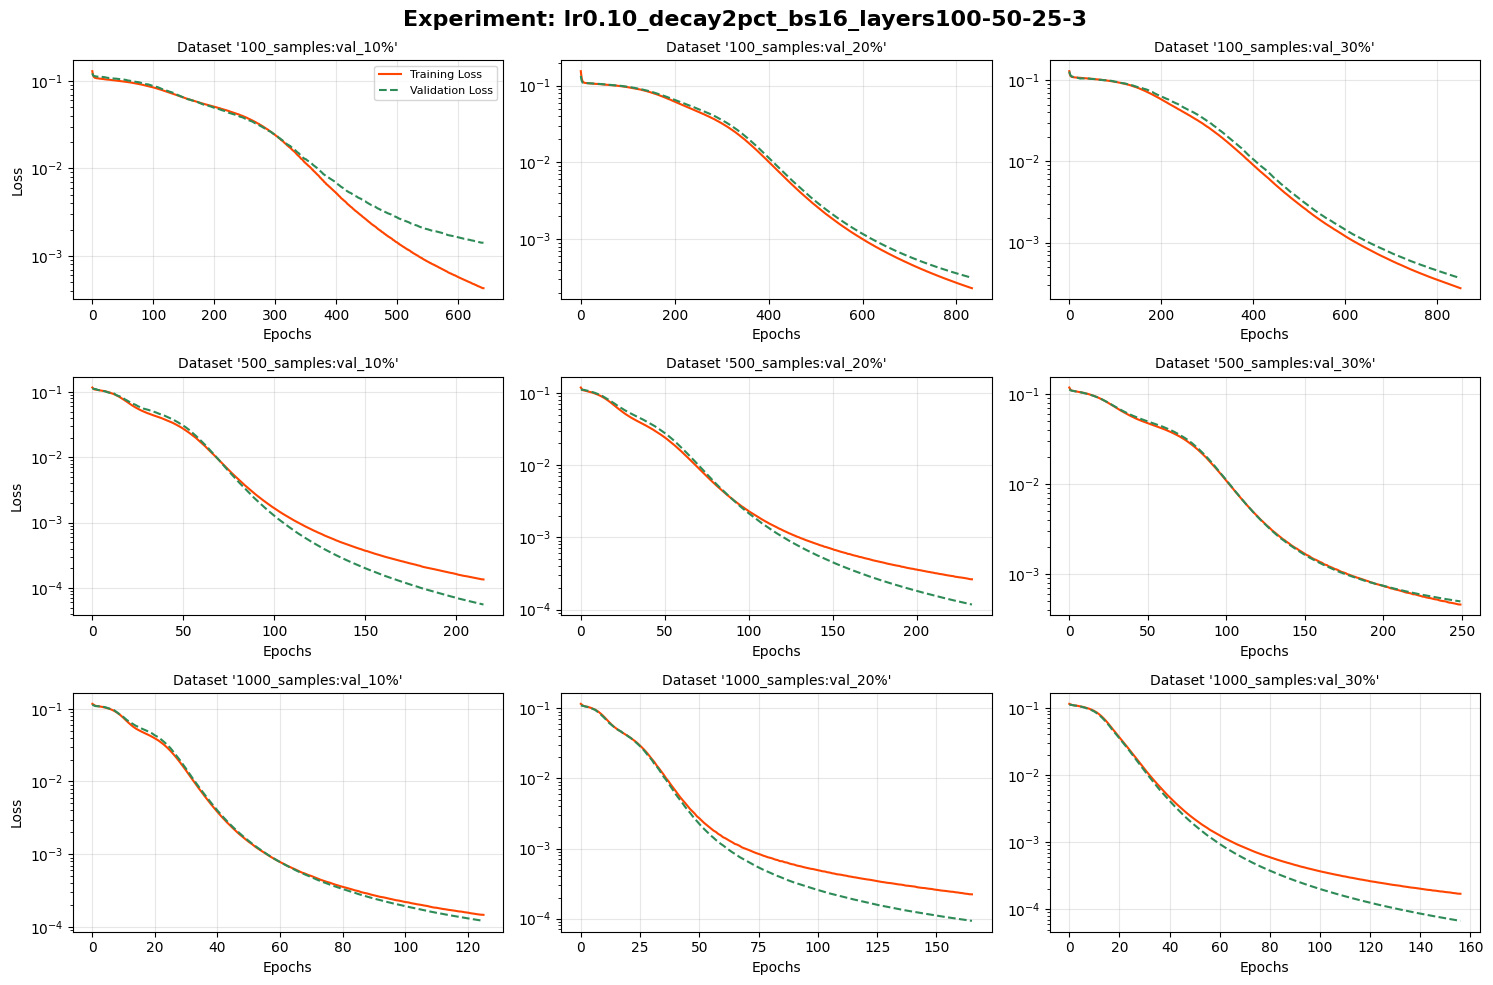

Experiment lr0.10_decay2pct_bs16_layers100-50-25-3 finished
  - Best dataset: 1000_samples:val_20% (val_loss_mean=0.012217)
  - Figure saved: grid_search_lr0.10_decay2pct_bs16_layers100-50-25-3.png

[4/150] Starting: lr0.10_decay2pct_bs8_layers100-50-25-3
--- Dataset 100_samples:val_10% (Mini-batch SGD) ---
|     0 |  0.1243333862 |    0.1189899044 |
|    25 |  0.0959418140 |    0.1004516895 |
|    25 |  0.0959418140 |    0.1004516895 |
|    50 |  0.0786005217 |    0.0815229298 |
|    50 |  0.0786005217 |    0.0815229298 |
|    75 |  0.0596046503 |    0.0600845268 |
|    75 |  0.0596046503 |    0.0600845268 |
|   100 |  0.0470560138 |    0.0455162514 |
|   100 |  0.0470560138 |    0.0455162514 |
|   125 |  0.0346768575 |    0.0338866604 |
|   125 |  0.0346768575 |    0.0338866604 |
|   150 |  0.0190853751 |    0.0190083886 |
|   150 |  0.0190853751 |    0.0190083886 |
|   175 |  0.0089720463 |    0.0103955336 |
|   175 |  0.0089720463 |    0.0103955336 |
|   200 |  0.0039856157 |    0.

KeyboardInterrupt: 

In [37]:
grid_search_minibatch(datasets)